In [56]:
import pandas as pd
from functions.displayer import (plot_cycle,
                                 plot_windowed_cycle,
                                 plot_loss,
                                 plot_reconstruction,
                                 plot_mae_per_cycle)
from functions.data_processor import DataProcessor
from models.encoder import Encoder
from models.decoder import Decoder
from models.autoencoder import Autoencoder
from functions.reconstruction import (reconstruct_cycles,
                                      calc_avg_mae_per_cycle)
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using autoencoders</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

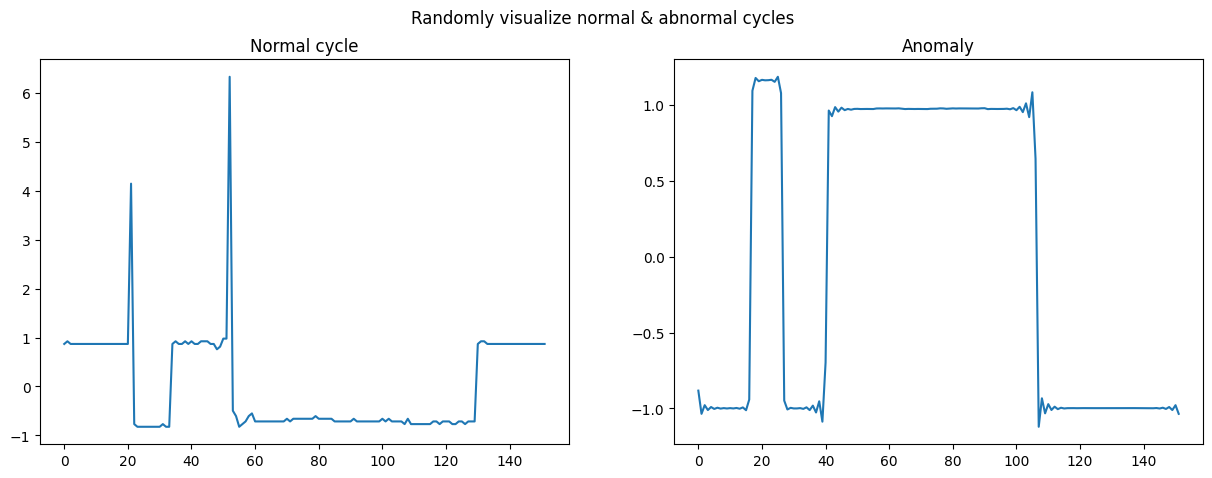

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


- Windowing: *Size = 32, gap = 8*

In [13]:
sub_length = 32
gap = 8

In [14]:
dp.windowing(sub_length, gap)

In [15]:
print('Train shape after windowing: ', dp.w_train.shape)

Train shape after windowing:  (14448, 32, 1)


- Visualize windowing overlapping impact

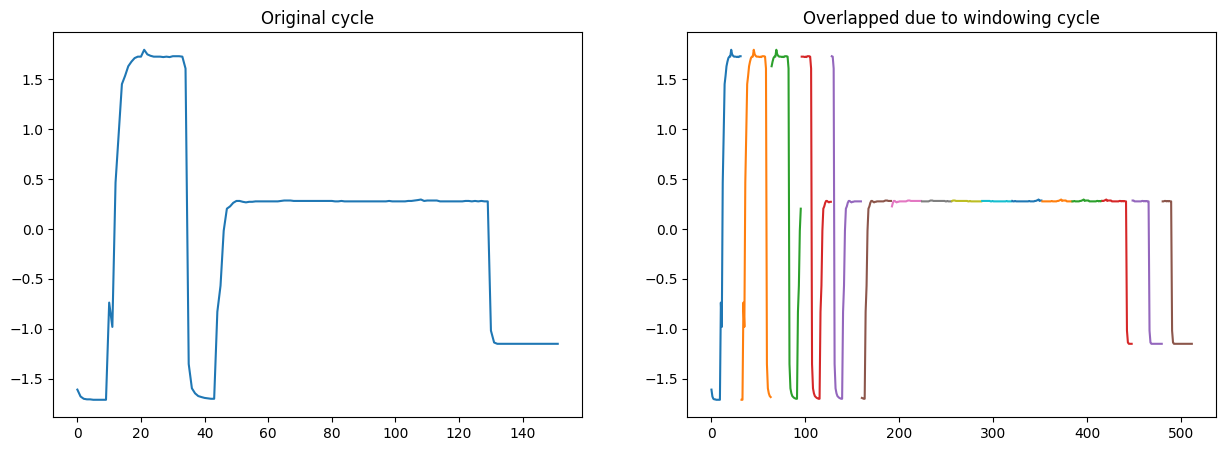

In [16]:
plot_windowed_cycle(dp.s_train, dp.w_train, gap=gap)

## II. Training an auto-encoder

#### 0. Dimensions definition

In [17]:
# Training set shape
shape = dp.w_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 4

#### 1. Create an LSTM encoder

In [18]:
encoder = Encoder(length_sequence, n_features, n_latent).model

#### 2. Create an LSTM decoder

In [19]:
decoder = Decoder(length_sequence, n_features, n_latent).model

#### 3. Create an auto-encoder

In [20]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [21]:
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Encoder-Model (Functional)  (None, 4)                 12804     
                                                                 
 Decoder-Model (Functional)  (None, 32, 1)             13089     
                                                                 
Total params: 25,893
Trainable params: 25,893
Non-trainable params: 0
_________________________________________________________________


#### 5. Fitting the model

- Training the model

In [22]:
history = ae.fit(x=dp.w_train,
                 y=dp.w_train,
                 batch_size=32,
                 epochs=15,
                 validation_data=(dp.w_test, dp.w_test))

Epoch 1/15
452/452 [==============================] - 44s 85ms/step - loss: 0.3371 - val_loss: 0.1898
Epoch 2/15
452/452 [==============================] - 39s 87ms/step - loss: 0.1619 - val_loss: 0.1334
Epoch 3/15
452/452 [==============================] - 39s 87ms/step - loss: 0.1255 - val_loss: 0.1138
Epoch 4/15
452/452 [==============================] - 41s 90ms/step - loss: 0.1110 - val_loss: 0.1056
Epoch 5/15
452/452 [==============================] - 39s 87ms/step - loss: 0.1016 - val_loss: 0.0933
Epoch 6/15
452/452 [==============================] - 40s 89ms/step - loss: 0.0931 - val_loss: 0.0906
Epoch 7/15
452/452 [==============================] - 41s 91ms/step - loss: 0.0887 - val_loss: 0.0822
Epoch 8/15
452/452 [==============================] - 41s 90ms/step - loss: 0.0872 - val_loss: 0.0747
Epoch 9/15
452/452 [==============================] - 43s 95ms/step - loss: 0.0826 - val_loss: 0.0787
Epoch 10/15
452/452 [==============================] - 48s 106ms/step - loss: 0.07

- Plotting loss functions

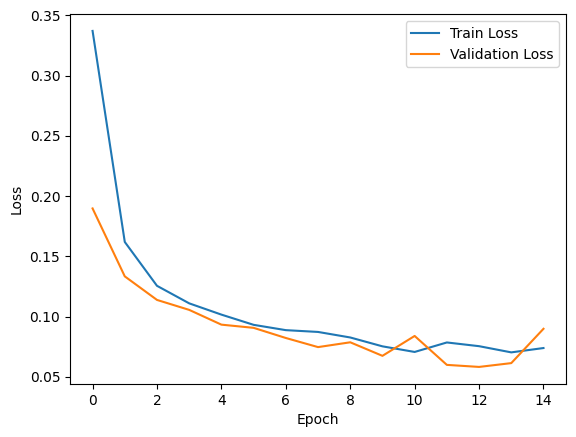

In [23]:
plot_loss(history)

#### 6. Test  windowed prediction

In [24]:
w_pred = ae.predict(dp.w_test)

3082/3082 [==============================] - 32s 10ms/step


#### 7. Visualize a windowed prediction

In [25]:
cycle = 5

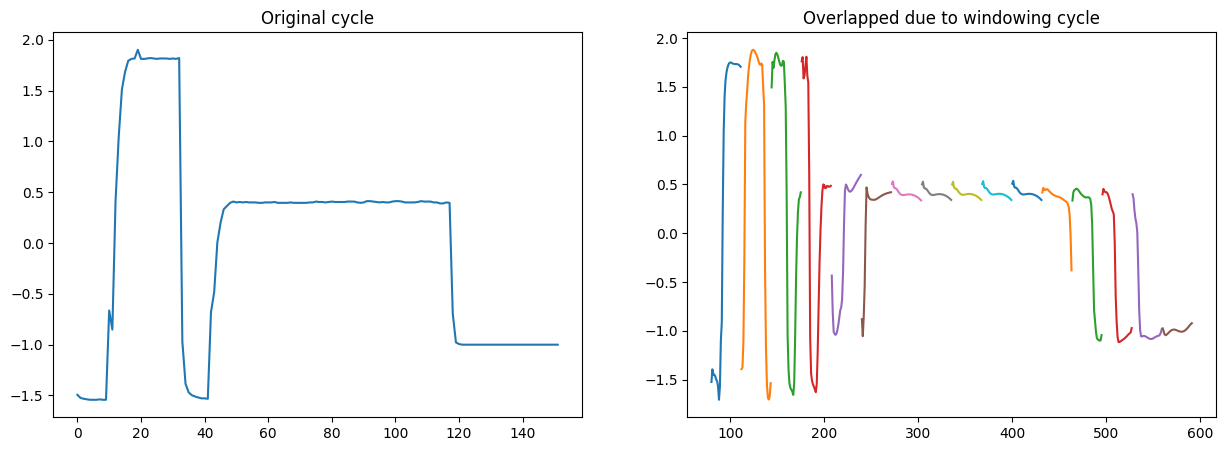

In [26]:
plot_windowed_cycle(dp.s_test, w_pred, cycle=cycle, gap=gap)

## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

- Calculate reconstructed cycles from windowed prediction by averaging over every overlap

In [27]:
import numpy as np

In [28]:
def reconstruct_cycles(W, length, sub_length=12, gap=4):
    """
    Reconstruct cycles from a given 3D numpy array.
    
    Parameters
    ----------
    W : numpy.ndarray
        A 3D numpy array of shape (n, m, k), where n, m, and k are the number of cycles, 
        sub-sequences, and features respectively. 
    length : int
        Length of the original sequence from which W was generated.
    sub_length : int, optional
        Length of each sub-sequence used to generate W. Default is 12.
    gap : int, optional
        Gap between sub-sequences used to generate W. Default is 4.
    
    Returns
    -------
    numpy.ndarray
        A 3D numpy array of shape (n, m, k) representing the reconstructed cycles
    """
    shape = W.shape
    n_sub_sequences = (length - sub_length) // gap + 1  # Calculate the number of sub-sequences needed to reconstruct the cycles
    cycles = []  # Initialize an empty list to store the reconstructed cycles
    for i in range(0, shape[0], n_sub_sequences):
        # Extract a subset of the input array that contains n_sub_sequences sub-sequences, starting from index i
        S = W[i:i+n_sub_sequences, :, :]
        cycle = S[0, :gap, :]  # Initialize the first part of the cycle with the first sub-sequence
        for j in range(1, n_sub_sequences-1):
            if j<sub_length//gap:
                min_present=0
            else:
                min_present=j-sub_length//gap+1
            cycle = np.concatenate([cycle, np.mean(np.stack([S[k, (j-k)*gap:(j-k+1)*gap, :] for k in range(min_present, j+1)], axis=0), axis=0)], axis=0)  # Average over present cycles in each overlapping gap
        cycle = np.concatenate([cycle, S[n_sub_sequences-1, :, :]], axis=0)  # Add the final sub-sequence to the cycle
        cycles.append(cycle)  # Add the reconstructed cycle to the list of cycles
    cycles = np.stack(cycles, axis=0)  # Stack the list of cycles into a 3D numpy array
    return cycles  # Return the reconstructed cycles

In [29]:
r_pred = reconstruct_cycles(w_pred, length=152, sub_length=sub_length, gap=gap)

In [30]:
r_pred.shape

(6164, 152, 1)

- Plotting reconstructed cycle

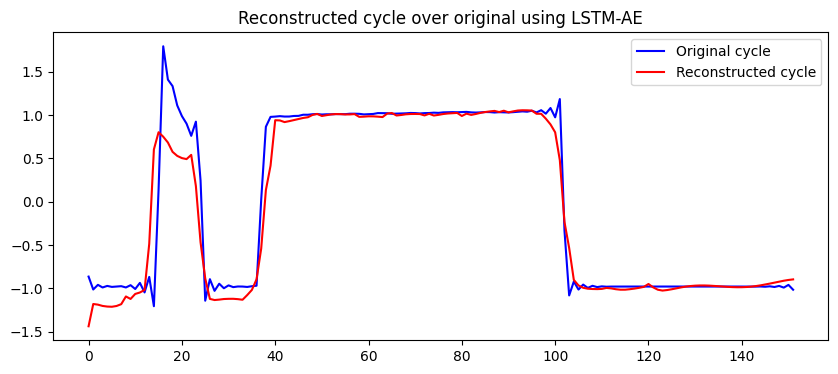

In [31]:
cycle = 6000
plot_reconstruction(dp.s_test, r_pred, cycle)

#### 2. Average reconstruction error per cycle

- Calculate the average mean absolute error (MAE) per cycle between a set of original 3D sequences and their reconstructions.

In [32]:
mae_per_cycle = calc_avg_mae_per_cycle(dp.s_test, r_pred)

- Plotting the average reconstruction error per cycle

In [33]:
def calc_avg_mae_per_cycle(original, reconstruction):
    """
    Calculate the average mean absolute error (MAE) per cycle between a set of
    original 3D sequences and their reconstructions.

    Parameters
    ----------
    original : array_like
        A 3D array of original sequences with shape (num_seqs, seq_len, num_features).
    reconstruction : array_like
        A 3D array of reconstructed sequences with shape (num_seqs, seq_len, num_features).

    Returns
    -------
    mae_per_cycle : ndarray
        A 1D array of average MAE per cycle with length equal to seq_len.
    """
    mae_per_cycle = np.mean(np.abs(original - reconstruction), axis=(1, 2))
    return mae_per_cycle

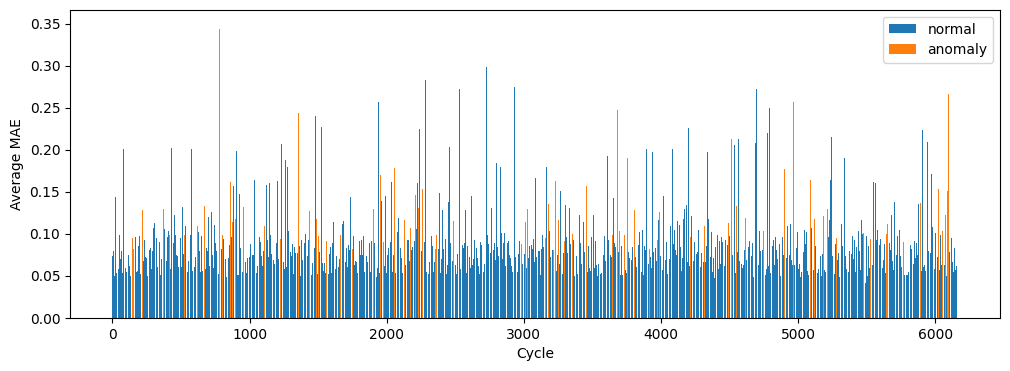

In [34]:
plot_mae_per_cycle(mae_per_cycle, y_test)

#### 3. Anomaly detection using a threshold on MAE per cycle

In [53]:
threshold = 0.09

In [54]:
y_pred = [1 if x<threshold else -1 for x in mae_per_cycle]

#### 4. Evaluation of anomaly detection using a threshold

In [57]:
accuracy = accuracy_score(y_test, y_pred)
confusion_m = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

In [64]:
print('Accuracy: %.2f' % accuracy, end='\n\n')
print('Confusion matrix: \n', confusion_m, end='\n\n')
print('Classification report: \n\n', cf_report)

Accuracy: 0.72

Confusion matrix: 
 [[ 628   37]
 [1691 3808]]

Classification report: 

               precision    recall  f1-score   support

          -1       0.27      0.94      0.42       665
           1       0.99      0.69      0.82      5499

    accuracy                           0.72      6164
   macro avg       0.63      0.82      0.62      6164
weighted avg       0.91      0.72      0.77      6164

